### Prepare environment

In [25]:
### Prepare environment
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}:")
# set proxy
_set_env("PROXY_VALUE")
proxy = os.getenv("PROXY_VALUE")
for proxy_var in ['HTTP_PROXY', 'HTTPS_PROXY', 'http_proxy', 'https_proxy']:
    os.environ[proxy_var] = proxy
# GOOGLE API KEY
_set_env("GOOGLE_API_KEY")
print("proxy_value:", proxy)

proxy_value: http://localhost:7897


### Set langsmith

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

### Agent
In the context of agents, waiting for user feedback is especially useful for asking clarifying qeustions.
To illustrate this, we'll create a simple ReAct-style agent capable of tool calling.

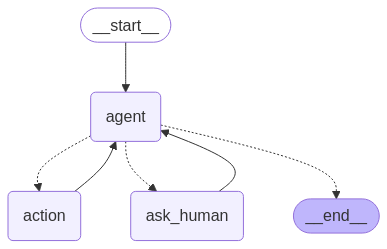

In [40]:
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool -a search tool
# We'll also have one "fake" tool -a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.types import Command, interrupt
from langchain_google_genai import ChatGoogleGenerativeAI

@tool
def search(query: str):
    """
    Call to surf the web.
    """
    # This is a placehodler for the acutal implementation
    # Don't let the LLM know this though
    return f"I looked up: {query}. Result: It's sunny in Chengdu, but you better look out if your're a Gemini."


tools = [search]
tool_node = ToolNode(tools)

# Set up the Gemini model
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0.2,
    max_tokens=512,
    timeout=None,
    max_retries=2
)

from pydantic import BaseModel

# We are going "bind" call tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""
    question: str

model = model.bind_tools(tools + [AskHuman])

# Define node and conditonal edges

# Define the function that determines whether to contine or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END

    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we contine
    else:
        return "action"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    ask = AskHuman.model_validate(state["messages"][-1].tool_calls[0]["args"])
    location = interrupt(ask.question)
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": location}]
    return {"messages": tool_message}


# Bild the graph
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)


# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node, we use `aget`.
    # This means that after `tools` is called, `agent` node is called next.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)


# We now add a normal edge form `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Finall, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory)


# Display graph image
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

    



### Interacting with the Agent
We can now interact with the agent. Let's ask it to ask the user wher they are, then tell them the weather.

This should make it use the `ask_human` tool first then use the normal tool.

### Interacting with the Agent¶
We can now interact with the agent. Let's ask it to ask the user where they are, then tell them the weather.



In [41]:
config = {"configurable": {"thread_id": "3"}}
for event in app.stream(
    {
        "messages": [
            (
                "user",
                "Ask the user where they are, then look up the weather there",
            )
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Ask the user where they are, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  AskHuman (9e95d26f-f32c-48ad-9aa0-b650706b8f98)
 Call ID: 9e95d26f-f32c-48ad-9aa0-b650706b8f98
  Args:
    question: Where are you located?


In [42]:
app.get_state(config).next

('ask_human',)

You can see that our graph got interrupted inside the `ask_human` node, which is now waiting for `location` to be provided. We can provide this value by ivoking the graph with a `Command(resume="<location>")` input:

In [43]:
for event in app.stream(Command(resume="ChengDu city"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  AskHuman (9e95d26f-f32c-48ad-9aa0-b650706b8f98)
 Call ID: 9e95d26f-f32c-48ad-9aa0-b650706b8f98
  Args:
    question: Where are you located?
================================= Tool Message =================================

ChengDu city
================================== Ai Message ==================================
Tool Calls:
  search (e0b1c8f4-6a01-4016-8576-1892044fb5e6)
 Call ID: e0b1c8f4-6a01-4016-8576-1892044fb5e6
  Args:
    query: weather in ChengDu city
================================= Tool Message =================================
Name: search

I looked up: weather in ChengDu city. Result: It's sunny in Chengdu, but you better look out if your're a Gemini.
================================== Ai Message ==================================

OK. It's sunny in Chengdu, but you better look out if your're a Gemini.
